In [1]:
%matplotlib widget
import torch
import os
import copy
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS, computeDT
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
dtype = torch.float32

nx = 64
dim = 1
kernel = 'CubicSpline'
targetNeighbors = n_h_to_nH(8, dim)
CFL = 0.3
goalRadius = 0.8

nx = 256
rho0 = 1
E0 = 1
gamma = 1.4

scheme = 'CompSPH'
integrationScheme = 'RK2'
viscositySwitch = 'hopkins'
supportScheme = 'Owen'

domain = buildDomainDescription(l = 1, dim = dim, periodic = True, device = device, dtype = dtype)
domain.min = torch.tensor([0, 0], device = device, dtype = dtype)
domain.max = torch.tensor([1, 1], device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)

In [3]:
import numpy as np
# Function to sample particles such that their density equals a desired PDF
def samplePDF(pdf, n = 2048, numParticles = 256, plot = False, randomSampling = False):
    x = np.linspace(-1,1,n)
    if plot:
        fig, axis = plt.subplots(1, 1, figsize=(9,6), sharex = False, sharey = False, squeeze = False)

    n = 2048
    xs = np.linspace(-1,1,n)

    if plot:
        axis[0,0].plot(xs, pdf(xs))

    normalized_pdf = lambda x: pdf(x) / np.sum(pdf(np.linspace(-1,1,n)))
    if plot:
        axis[0,0].plot(xs, normalized_pdf(xs))
        axis[0,0].axhline(0,ls= '--', color = 'black')


    xs = np.linspace(-1,1,n)
    fxs = normalized_pdf(xs)
    sampled_cdf = np.cumsum(fxs) - fxs[0]
    sampled_cdf = sampled_cdf / sampled_cdf[-1] 
    inv_cdf = lambda x : np.interp(x, sampled_cdf, np.linspace(-1,1,n))

    samples = np.random.uniform(size = numParticles)
    if not randomSampling:
        samples = np.linspace(0,1,numParticles, endpoint=False)
    sampled = inv_cdf(samples)

    return sampled

In [76]:
from sphMath.util import volumeToSupport
from sphMath.sampling import ParticleSet
domain = buildDomainDescription(l = 2, dim = dim, periodic = True, device = device, dtype = dtype)
print(domain.min, domain.max)
pdf = lambda x: 0.1 * np.sin(4*x * np.pi) + 2

tensor([-1.]) tensor([1.])


In [77]:
positions = torch.tensor(samplePDF(pdf, n = 2048, numParticles = 1024, plot = False, randomSampling = False), device = device, dtype = dtype).view(-1,1)
masses = torch.ones_like(positions[:,0]) * (domain.max - domain.min)[0]/positions.shape[0] * 2
densities = torch.tensor(pdf(positions[:,0].cpu().numpy()), device = device, dtype = dtype)
supports = volumeToSupport(masses, targetNeighbors, 1)

particles_l = ParticleSet(positions, supports, masses, densities)


In [78]:

from sphMath.modules.compressible import CompressibleState
from sphMath.modules.density import computeDensity
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr

Pinitial = torch.zeros_like(particles_l.densities)
r = torch.linalg.norm(particles_l.positions, dim = -1)
rhoInitial = torch.ones_like(particles_l.densities)
v_initial = - torch.nn.functional.normalize(particles_l.positions, dim = -1)
# particles_l = particles_l._replace(masses = particles_l.masses * rhoInitial, densities = rhoInitial)

A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)

internalEnergy = u_ 
kineticEnergy = torch.linalg.norm(v_initial, dim = -1) **2/ 2
totalEnergy = (internalEnergy + kineticEnergy) * particles_l.masses

simulationState = CompressibleState(
    positions = particles_l.positions,
    supports = particles_l.supports,
    masses = particles_l.masses,
    densities = particles_l.densities,        
    velocities = v_initial,
    
    internalEnergies = u_,
    totalEnergies = totalEnergy,
    entropies = A_,
    pressures = P_,
    soundspeeds = c_s,

    alphas = torch.ones_like(particles_l.densities),
    alpha0s = torch.ones_like(particles_l.densities)
)

neighborhood, sparseNeighborhood = buildNeighborhood(simulationState, simulationState, domain, 1.4, 'superSymmetric')
actualNeighbors = filterNeighborhood(sparseNeighborhood)

densities = computeDensity(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather')
A_, u_, P_, c_s = idealGasEOS(A = None, u = None, P = Pinitial, rho = particles_l.densities, gamma = gamma)
simulationState.internalEnergies = u_

particleSystem = SimulationSystem(
        systemState = simulationState,
        domain = domain,
        neighborhoodInfo = neighborhood,
        t = 0
    )

Text(0.5, 1.0, 'dx')

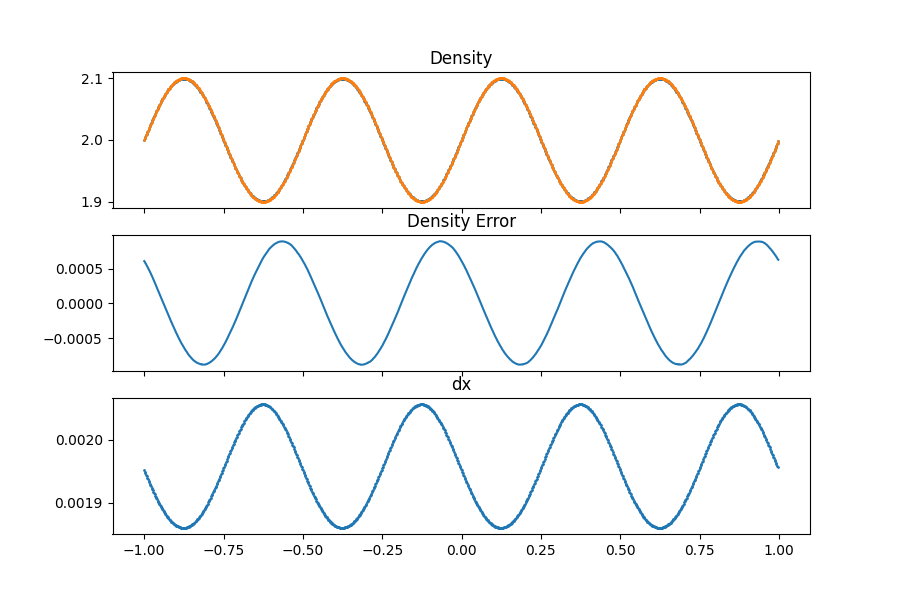

In [79]:
fig, axis = plt.subplots(3, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

x = particles_l.positions[:,0].cpu().numpy()
targetDensity = pdf(particles_l.positions[:,0].cpu().numpy())
currentDensity = densities.cpu().numpy()

axis[0,0].scatter(particleSystem.systemState.positions.cpu().numpy(), currentDensity, s = 1)
axis[0,0].scatter(particleSystem.systemState.positions.cpu().numpy(), targetDensity, s = 1)

axis[0,0].set_title('Density')

axis[1,0].plot(particleSystem.systemState.positions.cpu().numpy(), (currentDensity - targetDensity))
axis[1,0].set_title('Density Error')

axis[2,0].scatter(x[:-1], x[1:] - x[:-1], s = 1)
axis[2,0].set_title('dx')



In [80]:
from sphMath.gradientUtil import derivative, eval_fn_grad, Jacobian, Hessian, Patrician
from sphMath.neighborhood import computeDistanceTensor, SparseNeighborhood
from sphMath.sphOperations.shared import scatter_sum

tensor([1.8339, 1.8364, 1.8388,  ..., 1.8266, 1.8291, 1.8315],
       grad_fn=<ScatterAddBackward0>)
tensor([[[2045.4768]],

        [[2045.0076]],

        [[2044.7346]],

        ...,

        [[2046.5703]],

        [[2046.2422]],

        [[2045.7112]]], grad_fn=<CopySlices>)


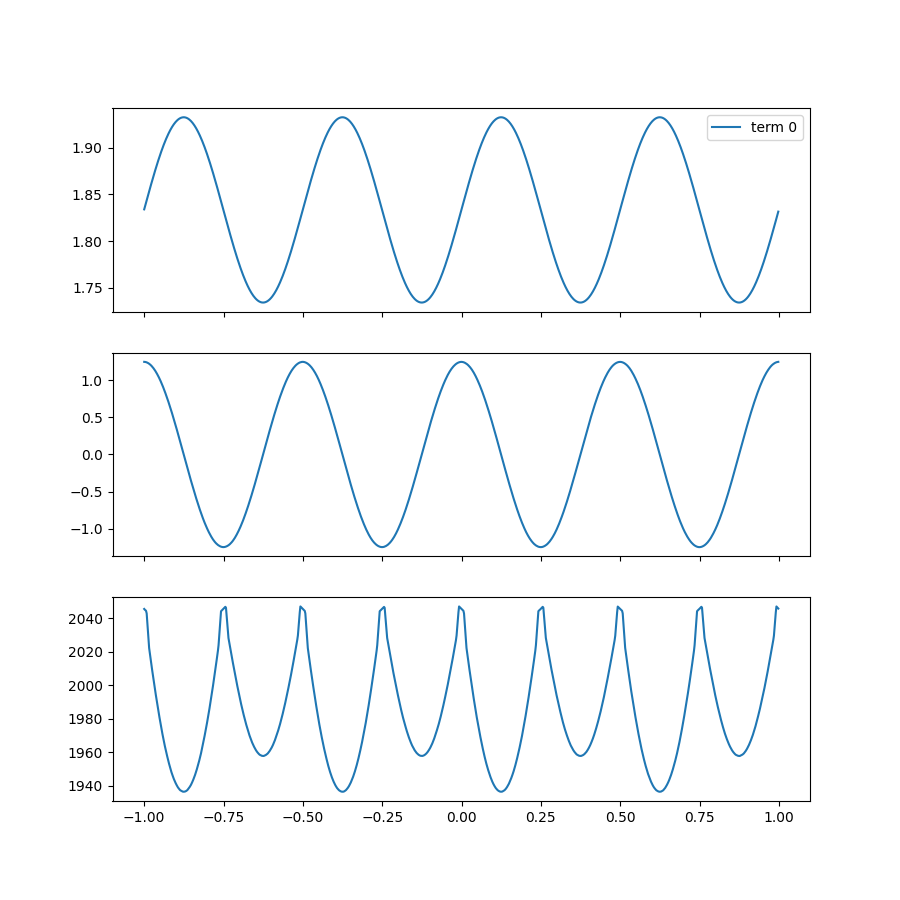

In [173]:
def evalDensity(x, simulationState, domain, kernel, neighborhood, supportScheme):
    # copiedState = copy.deepcopy(simulationState)
    # copiedState.positions = x
    # return computeDensity(copiedState, copiedState, domain, kernel, neighborhood, supportScheme)
    actualNeighbors = filterNeighborhood(neighborhood)
    i_, j_ = actualNeighbors.row, actualNeighbors.col
    i, j = i_, j_
    i = i_[i_!=j_]
    j = j_[i_!=j_]
    # i =i_[i_ == 0]
    # j = j_[i_ == 0]

    sparseNeighbors = SparseNeighborhood(
        row = i, col = j,
        numRows = neighborhood.numRows, numCols = neighborhood.numCols,
        points_a = PointCloud(x, simulationState.supports), points_b = PointCloud(simulationState.positions, simulationState.supports),
        domain = domain
    )

    rij, xij = computeDistanceTensor(sparseNeighbors, normalize=False, mode = supportScheme)
    W = solverConfig['kernel'].eval(xij, simulationState.supports[i])
    gradW = solverConfig['kernel'].jacobian(xij, simulationState.supports[i])

    # return gradW

    # term = simulationState.masses[j].view(-1,1) * gradW
    term = simulationState.masses[j] * W
    # return term
    return scatter_sum(term, i, dim = 0, dim_size = x.shape[0])


simulationState.densities = densities
rho_fn = lambda x: evalDensity(x, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather')

x_grad = particleSystem.systemState.positions.clone()
x_grad.requires_grad = True

terms = eval_fn_grad(rho_fn, x_grad, order = 2)

terms[0]
print(terms[0])

fig, axis = plt.subplots(len(terms), 1, figsize=(9,len(terms) * 3), sharex = True, sharey = False, squeeze = False)

# terms[-1] = terms[-1] - (2 * particleSystem.systemState.positions.shape[0])
# csr = coo_to_csr(actualNeighbors)
# terms[-1] /= csr.rowEntries.view(-1,1)

for it, t in enumerate(terms):
    axis[it,0].plot(x, t.flatten().cpu().detach().numpy(), label = f'term {it}')
axis[0,0].legend()

print(terms[-1])


tensor([[-0.0935],
        [-0.4768],
        [-0.8597],
        ...,
        [ 1.0533],
        [ 0.6717],
        [ 0.2897]], grad_fn=<ScatterAddBackward0>)
tensor([[[[-122210.3516]]],


        [[[-121870.0781]]],


        [[[-121434.2969]]],


        ...,


        [[[-122635.9297]]],


        [[[-122593.2891]]],


        [[[-122467.1719]]]], grad_fn=<CopySlices>)


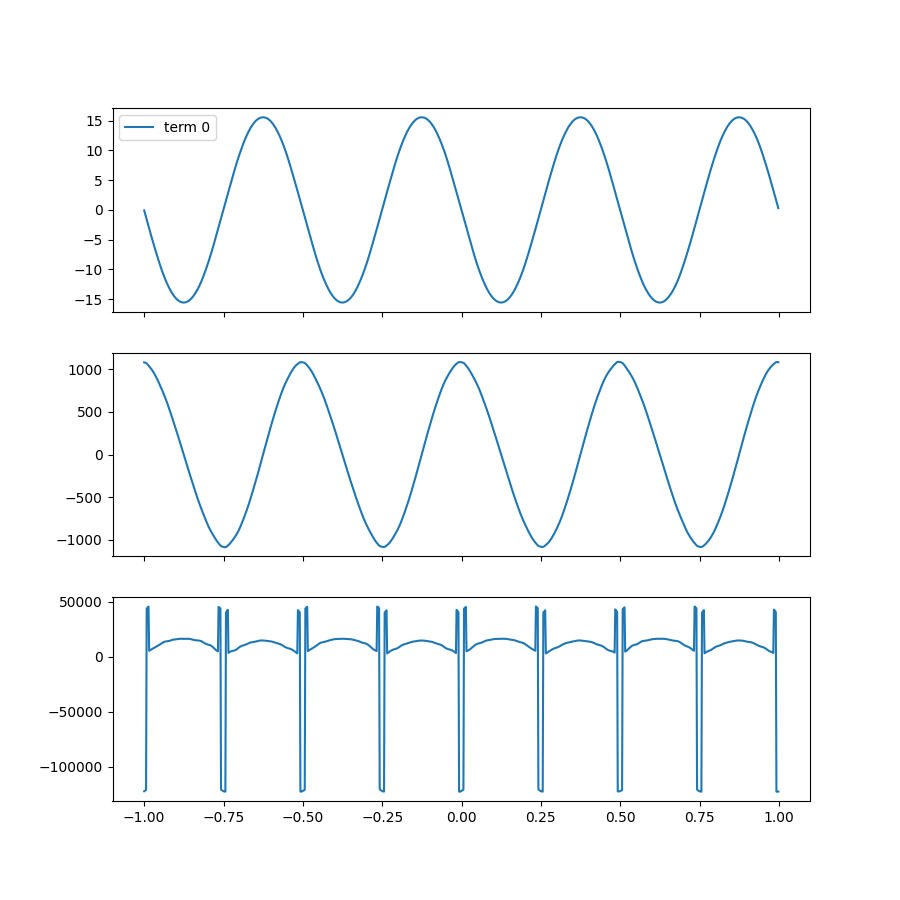

In [180]:
def evalDensity(x, simulationState, domain, kernel, neighborhood, supportScheme, rhoGrad):
    # copiedState = copy.deepcopy(simulationState)
    # copiedState.positions = x
    # return computeDensity(copiedState, copiedState, domain, kernel, neighborhood, supportScheme)
    actualNeighbors = filterNeighborhood(neighborhood)
    i_, j_ = actualNeighbors.row, actualNeighbors.col
    i, j = i_, j_
    i = i_[i_!=j_]
    j = j_[i_!=j_]
    # i =i_[i_ == 0]
    # j = j_[i_ == 0]

    sparseNeighbors = SparseNeighborhood(
        row = i, col = j,
        numRows = neighborhood.numRows, numCols = neighborhood.numCols,
        points_a = PointCloud(x, simulationState.supports), points_b = PointCloud(simulationState.positions, simulationState.supports),
        domain = domain
    )

    rij, xij = computeDistanceTensor(sparseNeighbors, normalize=False, mode = supportScheme)
    W = solverConfig['kernel'].eval(xij, simulationState.supports[i])
    gradW = solverConfig['kernel'].jacobian(xij, simulationState.supports[i])

    # return gradW

    fac = simulationState.masses[j] / simulationState.densities[j] * rhoGrad[j]

    term = fac.view(-1,1) * gradW 
    # term = simulationState.masses[j] * W
    # return term
    return scatter_sum(term, i, dim = 0, dim_size = x.shape[0])

from sphMath.sphOperations.shared import scatter_sum
from sphMath.operations import sph_op
import torch.autograd as autograd

gradRho = sph_op(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather', 'gradient', gradientMode = 'naive', quantity=densities)[:,0]
simulationState.densities = densities
rho_fn = lambda x: evalDensity(x, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather', gradRho)

x_grad = particleSystem.systemState.positions.clone()
x_grad.requires_grad = True

terms = eval_fn_grad(rho_fn, x_grad, order = 2)

terms[0]
print(terms[0])

fig, axis = plt.subplots(len(terms), 1, figsize=(9,len(terms) * 3), sharex = True, sharey = False, squeeze = False)

# terms[-1] = terms[-1] - (2 * particleSystem.systemState.positions.shape[0])
# csr = coo_to_csr(actualNeighbors)
# terms[-1] /= csr.rowEntries.view(-1,1)

for it, t in enumerate(terms):
    axis[it,0].plot(x, t.flatten().cpu().detach().numpy(), label = f'term {it}')
axis[0,0].legend()

print(terms[-1])


In [156]:
i_, j_ = actualNeighbors.row, actualNeighbors.col
i, j = i_, j_
# i = i_[i_!=j_]
# j = j_[i_!=j_]
# i =i_[i_ == 0]
# j = j_[i_ == 0]

sparseNeighbors = SparseNeighborhood(
    row = i, col = j,
    numRows = actualNeighbors.numRows, numCols = actualNeighbors.numCols,
    points_a = PointCloud(x_grad, simulationState.supports), points_b = PointCloud(simulationState.positions, simulationState.supports),
    domain = domain
)

rij, xij = computeDistanceTensor(sparseNeighbors, normalize=False, mode = 'gather')

W = solverConfig['kernel'].eval(xij, simulationState.supports[i])
gradW = solverConfig['kernel'].jacobian(xij, simulationState.supports[i])
hessW = solverConfig['kernel'].hessian(xij, simulationState.supports[i])

print(hessW.shape)

gw = scatter_sum(simulationState.masses[j].view(-1,1) * gradW, i, dim = 0, dim_size = x_grad.shape[0])[:,0]
hw = scatter_sum(simulationState.masses[j].view(-1,1) * hessW, i, dim = 0, dim_size = x_grad.shape[0])[:,0]

print((gw - terms[0]).abs().max())
print(hessW.shape)
print(terms[1].shape)

torch.Size([32800, 1, 1])
tensor(0., grad_fn=<MaxBackward1>)
torch.Size([32800, 1, 1])
torch.Size([1024, 1])


In [162]:
lap = simulationState.masses[j] * solverConfig['kernel'].laplacian(xij, simulationState.supports[i])
lap = scatter_sum(lap, i, dim = 0, dim_size = x_grad.shape[0])
print(lap)

tensor([2045.3569, 2044.8882, 2044.6143,  ..., 2046.4515, 2046.1232,
        2045.5916], grad_fn=<ScatterAddBackward0>)


In [151]:
print(terms[0].shape)
print(terms[1].shape)

torch.Size([1024])
torch.Size([1024, 1])


In [159]:
print((hw - terms[1]).abs().max())

tensor(0.0010, grad_fn=<MaxBackward1>)


In [158]:
print(hw)

tensor([[2045.4766],
        [2045.0078],
        [2044.7344],
        ...,
        [2046.5703],
        [2046.2422],
        [2045.7109]], grad_fn=<SelectBackward0>)


In [135]:
hessW.sum()

tensor(523642., grad_fn=<SumBackward0>)

In [96]:
positions.shape

torch.Size([1024, 1])

In [82]:
print(torch.any(torch.isnan(terms[1])), torch.any(torch.isinf(terms[1])))

tensor(False) tensor(False)


In [83]:
from sphMath.sphOperations.shared import scatter_sum
from sphMath.operations import sph_op
import torch.autograd as autograd

simulationState.densities = densities
gradRho = sph_op(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather', 'gradient', gradientMode = 'naive', quantity=densities)[:,0]
secondRho = sph_op(simulationState, simulationState, domain, solverConfig['kernel'], actualNeighbors, 'gather', 'gradient', gradientMode = 'naive', quantity=gradRho)
print(secondRho.min(), secondRho.max(), secondRho.mean())

tensor(-15.5697) tensor(15.5531) tensor(-0.3910)


tensor([[1.2509],
        [1.2504],
        [1.2491],
        ...,
        [1.2480],
        [1.2494],
        [1.2509]], grad_fn=<IndexPutImplBackward0>)


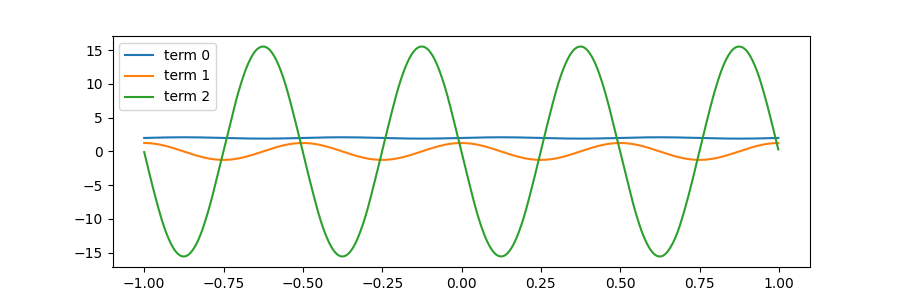

In [85]:

fig, axis = plt.subplots(1, 1, figsize=(9,3), sharex = True, sharey = False, squeeze = False)

axis[0,0].plot(x, densities.cpu().numpy(), label = 'term 0')
axis[0,0].plot(x, gradRho.cpu().numpy(), label = 'term 1')
axis[0,0].plot(x, secondRho.cpu().numpy(), label = 'term 2')

axis[0,0].legend()

print(terms[-2])


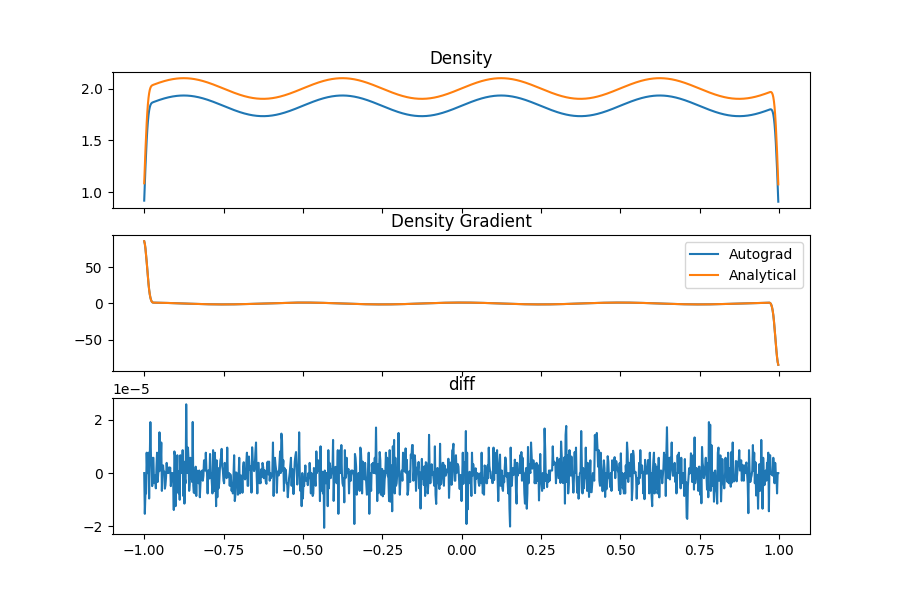

In [74]:
fig, axis = plt.subplots(3, 1, figsize=(9,6), sharex = True, sharey = False, squeeze = False)

x = particles_l.positions[:,0].cpu().numpy()
targetDensity = pdf(particles_l.positions[:,0].cpu().numpy())
currentDensity = densities.cpu().numpy()

axis[0,0].plot(particleSystem.systemState.positions.cpu().numpy(), terms[0].flatten().detach().cpu().numpy())
axis[0,0].plot(particleSystem.systemState.positions.cpu().numpy(), densities.flatten().detach().cpu().numpy())

axis[0,0].set_title('Density')

axis[1,0].plot(x_grad.detach().cpu().numpy(), terms[1].flatten().detach().cpu().numpy(), label = 'Autograd')
axis[1,0].plot(x_grad.detach().cpu().numpy(), gradRho.detach().cpu().numpy(), label = 'Analytical')
axis[1,0].set_title('Density Gradient')
axis[1,0].legend()

axis[2,0].set_title('diff')
axis[2,0].plot(x_grad.detach().cpu().numpy(), terms[1].flatten().detach().cpu().numpy() - gradRho.detach().cpu().numpy())

